In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
#source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
#players <- read_csv("data/players.csv")
#sessions <- read_csv("data/players.csv")
players <- read_csv("https://raw.githubusercontent.com/Jay7615/Project/refs/heads/main/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/Jay7615/Project/refs/heads/main/sessions.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [8]:

# Summary statistics
cat("\nSummary statistics for players dataset:")
summary(players)
cat("\nSummary statistics for sessions dataset:")
summary(sessions)

# Check for missing values
cat("\nMissing values in players dataset:")
print(colSums(is.na(players)))
cat("\nMissing values in sessions dataset:")
print(colSums(is.na(sessions)))





Summary statistics for players dataset:

  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 8.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :20.52  
                                       3rd Qu.:22.00  
                                       Max.   :50.00  
                               


Summary statistics for sessions dataset:

 hashedEmail         start_time          end_time         original_start_time
 Length:1535        Length:1535        Length:1535        Min.   :1.712e+12  
 Class :character   Class :character   Class :character   1st Qu.:1.716e+12  
 Mode  :character   Mode  :character   Mode  :character   Median :1.719e+12  
                                                          Mean   :1.719e+12  
                                                          3rd Qu.:1.722e+12  
                                                          Max.   :1.727e+12  
                                                                             
 original_end_time  
 Min.   :1.712e+12  
 1st Qu.:1.716e+12  
 Median :1.719e+12  
 Mean   :1.719e+12  
 3rd Qu.:1.722e+12  
 Max.   :1.727e+12  
 NA's   :2          


Missing values in players dataset:  experience    subscribe  hashedEmail played_hours         name       gender 
           0            0            0            0            0            0 
         Age 
           2 

Missing values in sessions dataset:        hashedEmail          start_time            end_time original_start_time 
                  0                   0                   2                   0 
  original_end_time 
                  2 


# 1) Data Description:

# Data Description for `players.csv`

## Dataset Overview
- **Number of Observations**: 196  
- **Number of Variables**: 7  
- **Data Collection Method**: Collected from a Minecraft server tracking player actions, demographics, and subscription status.  

---

## Variables Summary

| Variable Name     | Type       | Description                                                                 | Notes                                                                                   |
|-------------------|------------|-----------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| `experience`      | Categorical (chr) | Player's self-reported skill level                                         | `Beginner`, `Amateur`, `Regular`, `Veteran`, `Pro`                                      |
| `subscribe`       | Categorical (lgl)| Whether the player subscribed to the newsletter                            | `TRUE`/`FALSE`                                                                          |
| `hashedEmail`     | String (chr)     | Unique hashed identifier for player emails                                 | SHA-256 hashes (e.g., `f6daba42...`)                                                    |
| `played_hours`    | Numeric (dbl)     | Total hours the player spent on the server                                 | Float values (e.g., `30.3`, `0`, `223.1`)                                               |
| `name`            | String (chr)    | Player's name                                                              | Unique per player (e.g., `Morgan`, `Kyrie`, `Akio`)                                     |
| `gender`          | Categorical (chr) | Player's self-reported gender identity                                     | `Male`, `Female`, `Non-binary`, `Prefer not to say`, `Two-Spirited`, `Agender`, `Other` |
| `Age`             | Numeric (dbl) | Player's age                                                               | Range: `8`–`50`; includes `NA` (missing values)                                         |

---

## Summary Statistics

### Numeric Variables
- **`played_hours`**  
  - **Mean**: 5.846 hours  
  - **Median**: 0.1 hours  
  - **Range**: 0–223.1 hours  
  - **Standard Deviation**: 28.4 hours  

- **`Age`**  
  - **Mean**: 20.52 years  
  - **Median**: 19.00 years  
  - **Range**: `8`–`50` years
  - **Standard Deviation**: 6.17 years
  - **Missing Values**: 2 entries

### Categorical Variables
- **`experience`**
    - `Amateur` 32% (64)
    - `Beginner` 18% (35)
    - `Beginner` 18% (35)
    - `Veteran` 24% (48)
    - `Pro` 7% (14)


- **`subscribe`**  
  - 73% (144) subscribed (`TRUE`), 27% (52) did not (`FALSE`).  

- **`gender`**  
  - Majority: `Male`63% (124), `Female` 19% (37).  
  - Minorities: `Non-binary` 8% (15), `Prefer not to say` 6% (11%), `Agender` 2% (1), 
                `Two-Spirited` 3% (6), `others` <1% (1).
---

## Data Issues
1. **Missing Values**:  
   - `Age` has 2 `NA` entries (`Devin` and `Ahmed` have `NA`).  
2. **Ambiguous Definitions**:  
   - `experience` levels are not clearly defined (self-reported vs. measured).  
   - `played_hours` timeframe is unclear (lifetime total or specific period?).  
3. **Inconsistent naming conventions**:
   - Most variable names are in snake_case  (e.g., played_hours)
   - `hashedEmail` uses camelCase
   - `Age` is capitalized


# Data Description for `sessions.csv`
- **Number of Observations**: 1,535  
- **Number of Variables**: 5  
- **Data Collection Method**: Logged player session data from a Minecraft server.  

---

### Variables Summary

| Variable Name         | Type      | Description                                                       | Notes |
|-----------------------|----------|-------------------------------------------------------------------|-------|
| `hashedEmail`        | String   | Unique hashed identifier for player emails                        | SHA-256 hashes, anonymized. |
| `start_time`         | String   | Session start time (formatted as `DD/MM/YYYY HH:MM`)              | Needs conversion to datetime. |
| `end_time`           | String   | Session end time (formatted as `DD/MM/YYYY HH:MM`)                | Some missing values (`NA`). |
| `original_start_time`| Float    | Unix timestamp of session start                                  | Needs conversion to datetime. |
| `original_end_time`  | Float    | Unix timestamp of session end                                    | Some missing values (`NA`). |

---

### Data Issues
1. **Missing Values**:  
   - `end_time` and `original_end_time` have two missing values.  
   -  If `end_time` is missing, it’s unclear if the session was ongoing or if data was lost. 
2. **Data Format Issues**:  
   - `start_time` and `end_time` should be converted to datetime objects.  

---


In [26]:

cat("\nNumber of observations in players dataset:", nrow(players))
cat("\nNumber of variables in players dataset:", ncol(players))
cat("\nNumber of observations in sessions dataset:", nrow(sessions))
cat("\nNumber of variables in sessions dataset:", ncol(sessions))
gender_counts <- table(players$gender)
gender_counts
gender_proportions <- prop.table(gender_counts)
gender_proportions
experience_counts <- table(players$experience)
experience_counts
experience_proportions <- prop.table(experience_counts)
experience_proportions
subscribe_counts <- table(players$subscribe)
subscribe_counts
subscribe_proportions <- prop.table(subscribe_counts)
subscribe_proportions
sum(duplicated(players$hashedEmail))
sum(duplicated(players$name))
sd(players$played_hours, na.rm = TRUE) 
sd(players$Age, na.rm = TRUE)  


Number of observations in players dataset: 196
Number of variables in players dataset: 7
Number of observations in sessions dataset: 196
Number of variables in sessions dataset: 7


          Agender            Female              Male        Non-binary 
                2                37               124                15 
            Other Prefer not to say      Two-Spirited 
                1                11                 6 


          Agender            Female              Male        Non-binary 
      0.010204082       0.188775510       0.632653061       0.076530612 
            Other Prefer not to say      Two-Spirited 
      0.005102041       0.056122449       0.030612245 


 Amateur Beginner      Pro  Regular  Veteran 
      63       35       14       36       48 


   Amateur   Beginner        Pro    Regular    Veteran 
0.32142857 0.17857143 0.07142857 0.18367347 0.24489796 


FALSE  TRUE 
   52   144 


    FALSE      TRUE 
0.2653061 0.7346939 

[1] 0

[1] 0

[1] 28.35734

[1] 6.174667

In [ ]:
sorted_data <- players %>%
  arrange(desc(played_hours))
head(sorted_data) 

In [ ]:
sum(is.na(players$Age))  
players_na_age <- players |>
                  filter(is.na(Age)) 
players_na_age
colSums(is.na(players))

In [ ]:
zero_hours_players <- players |>
                      filter(played_hours == 0)
zero_hours_players
zero_hours_count = nrow(zero_hours_players)
total_players <- nrow(players)

zero_hours_percentage <- (zero_hours_count / total_players) * 100
zero_hours_percentage

In [ ]:
# Load necessary libraries
library(dplyr)
library(lubridate)

# Load dataset
df <- sessions 

# Convert date-time columns to proper format
df$start_time <- dmy_hm(df$start_time)
df$end_time <- dmy_hm(df$end_time)

# Convert Unix timestamps to datetime
df$original_start_time <- as.POSIXct(df$original_start_time / 1000, origin = "1970-01-01")
df$original_end_time <- as.POSIXct(df$original_end_time / 1000, origin = "1970-01-01")

# Calculate session duration
df$session_duration <- as.numeric(difftime(df$end_time, df$start_time, units = "mins"))

# Summary statistics
summary_report <- df |> summarise(
  total_sessions = n(),
  missing_end_times = sum(is.na(end_time)),
  avg_session_duration = mean(session_duration, na.rm = TRUE),
  median_session_duration = median(session_duration, na.rm = TRUE),
  min_session_duration = min(session_duration, na.rm = TRUE),
  max_session_duration = max(session_duration, na.rm = TRUE)
)

# Print summary report
print(summary_report)


# (2) Questions:

### **Broad Research Question**  
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? 

---

### **Specific Predictive Question**  
**Can a player’s *experience level*, *played hours*, *age*, and *gender* predict their likelihood of subscribing to the newsletter (*subscribe*) in the Minecraft server dataset?**

---

### **Response Variable**  
- **`subscribe`**: Logical variable (`TRUE`/`FALSE`) indicating whether the player subscribed to the newsletter.  

---

### **How to Data Wrangling**  
    - Convert `subscribe`, `experience`and 'gender' into factors for modeling.
    - Handle missing values in `Age` (e.g., impute with median or exclude rows with `NA`).  
---
## **How the Data Answers the Question**  
1. **Pattern Identification**:  
   - KNN classifies players based on similarity to neighbors. For example:  
     - Players with high `played_hours` and `Regular` status may cluster together and show higher subscription rates.  
     - Younger players (`Age` < 20) might form a distinct group with unique subscription behaviors.  

2. **Predictive Power**:  
   - The model quantifies how well the combination of `experience`, `played_hours`, `Age`, and `gender` predicts subscription status.   

3. **New Insights**:  
   - If `played_hours` and `experience` are key predictors, stakeholders can:  
     - Target `Amateur`/`Veteran` players for newsletter promotions.  
     - Incentivize people who have played a lot to boost subscriptions.  
   - Gender-based trends might give new strategies to targets certain groups. 



# (3) Exploratory Data Analysis and Visualization

In [33]:
players <- players |>
  mutate(
    experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro")),
    subscribe = factor(subscribe),
    gender = factor(gender)
  )
players$Age <- ifelse(is.na(players$Age), median(players,Age, na.rm = TRUE), players$Age)

| Variable      | Mean       |
|---------------|------------|
| played_hours  | 5.846 hours  |
| Age           | 20.52 years |

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


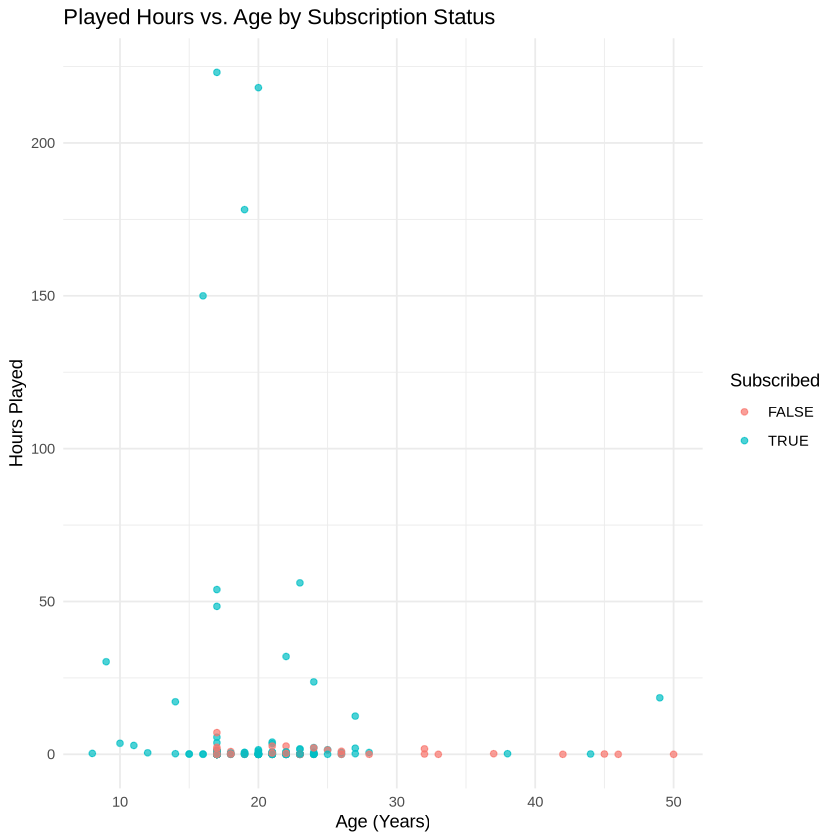

In [19]:
ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.7) +
  labs(
    title = "Played Hours vs. Age by Subscription Status",
    x = "Age (Years)",
    y = "Hours Played",
    color = "Subscribed"
  ) +
  theme_minimal()

**Insight**:
Only people who have have few hours (< 10) played are not going to subscribe
People who have played more than a few hours (> 10) are going to subsribe.
Younger players (<20 years) with moderate playtime (10–50 hours) are more likely to subscribe.

`summarise()` has grouped output by 'gender'. You can override using the
`.groups` argument.


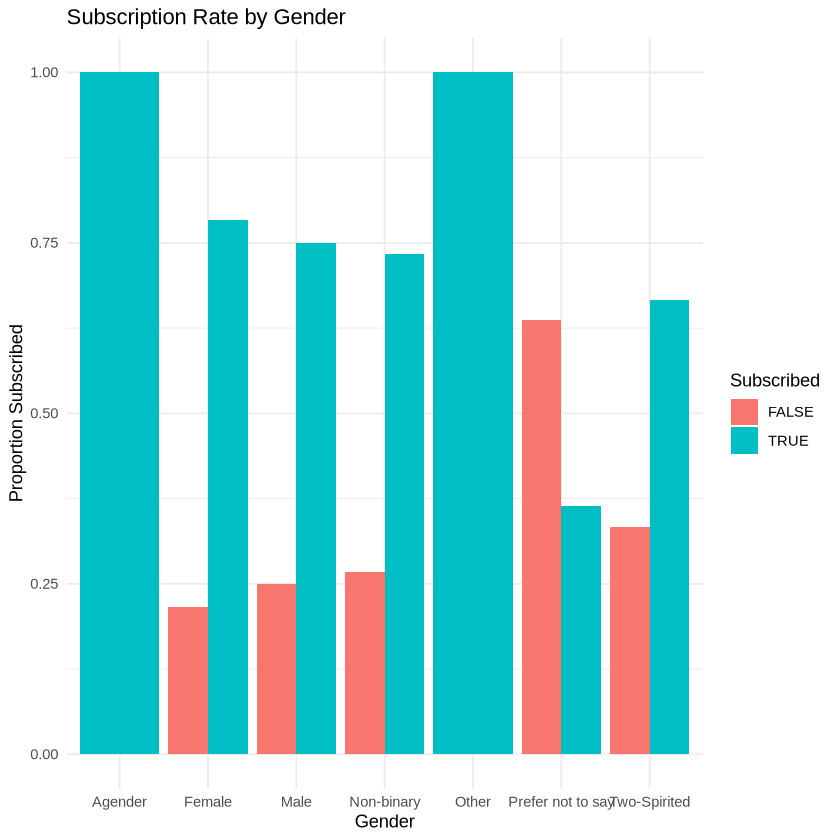

In [21]:
players %>%
  group_by(gender, subscribe) |>
  summarise(count = n()) |>
  mutate(proportion = count / sum(count)) |>
  ggplot(aes(x = gender, y = proportion, fill = subscribe)) +
  geom_col(position = "dodge") +
  labs(
    title = "Subscription Rate by Gender",
    x = "Gender",
    y = "Proportion Subscribed",
    fill = "Subscribed"
  ) +
  theme_minimal()

**Insight**:
Most gender groups tend to subscribe more than not subscribe (Except Prefer not say to say)
Gender-specific campaigns might improve engagement in underrepresented groups.

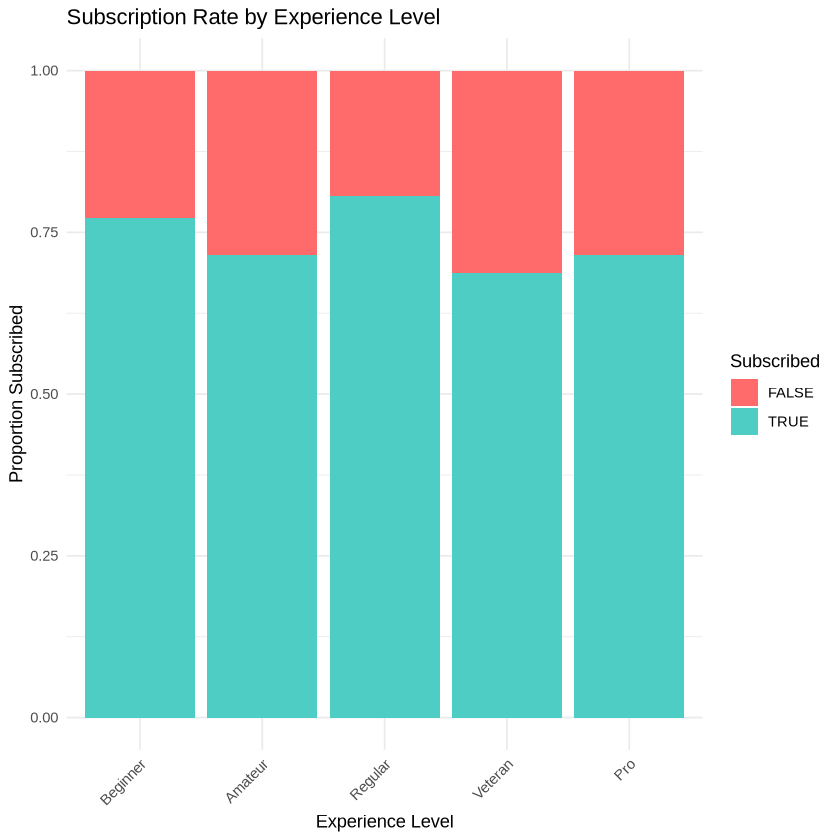

In [22]:
ggplot(players, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  scale_fill_manual(values = c("#FF6B6B", "#4ECDC4")) +
  labs(
    title = "Subscription Rate by Experience Level",
    x = "Experience Level",
    y = "Proportion Subscribed",
    fill = "Subscribed"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

**Insight**:
Lower experience tiers (e.g., Beginner, Pro) show higher subscription proportions.
Stakeholders could target lower experienced players for newsletter promotions.

# (4) Methods and Plan
# Method Proposal: K-Nearest Neighbors (KNN) Classification

## **Why KNN Classification is Appropriate**  
1. **Problem Type**: Binary classification (`subscribe` = `TRUE`/`FALSE`) that can be change into categorical.  
2. **Mixed Data Types**: Handles both numeric (`played_hours`, `Age`) and categorical (`experience`, `gender`) predictors after preprocessing.  
3. **Non-Linearity**: Can compure multiple relationships without assuming linearity (e.g., high `played_hours` + `Regular` status).
## **Key Assumptions**  
1. **Feature Scaling**: Numeric variables must be normalized to ensure equal weighting in distance calculations.  
2. **Relevant Predictors**: The selected features (`experience`, `played_hours`, `Age`, `gender`) are meaningful for predicting subscriptions.
   
## **Potential Limitations**  
1. **Outliers**: Extreme `played_hours` values (e.g., 223 hours) and many players with little to no hours played (e.g., < 1) may distort distance metrics.  
2. **Class Imbalance**: Subscribed players (`TRUE`) dominate (73%), potentially biasing predictions.  

### **Metrics for Comparison**
- **Accuracy**: Overall proportion of correct predictions.
- **Precision**: Proportion of true subscribers among predicted subscribers (minimize false positives).
- **Recall**: Proportion of actual subscribers correctly identified (minimize false negatives).

## **How to Process the Data**  
- **Split**: 80% training, 20% testing.
- **Find K** Use **5-fold cross-validation** to find k (K = 8) 
- **Stratification**: Ensure traing and testing set have the same `subscribe` distribution
- **Timing**: Split before preprocessing to avoid data leakage into the training process.

In [30]:
set.seed(123)
players_split <- initial_split(players, prop = 0.8, strata = subscribe)
training_set <- training(players_split)
testing_set <- testing(players_split)

knn_recipe <- recipe(subscribe ~ experience + played_hours + Age + gender, 
                    data = training_set) |>
  step_impute_median(Age) |>                
  step_normalize(all_numeric_predictors())  

knn_spec <- nearest_neighbor(
  weight_func = "rectangular", 
  neighbors = tune()
) |>
  set_mode("classification") |> 
  set_engine("kknn")

cv_folds <- vfold_cv(training_set, v = 5, strata = subscribe)

knn_workflow <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec)

knn_tune <- knn_workflow |> 
  tune_grid(
    resamples = cv_folds,
    grid = tibble(neighbors = seq(2, 20, by = 2)),  # Wider range for k
    metrics = metric_set(accuracy, roc_auc)          # Multiple metrics
  )

# Select best k based on accuracy
best_k <- select_best(knn_tune, metric = "accuracy")$neighbors
best_k

[1] 8